In [1]:
import numpy as np
from sklearn.manifold import TSNE
import json
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
full_embedding_files = glob.glob('../preprocess/data/full_text_embedding/*.json')
all_embeddings = []
for file in full_embedding_files:
    article_w_embedding = json.load(open(file))
    all_embeddings.append(article_w_embedding)
save_json(all_embeddings, '../preprocess/data/full/full_embedding.json')


In [6]:
full_embeddings = json.load(open('../preprocess/data/full/full_embedding.json'))
summary_embeddings = json.load(open('../preprocess/data/summary/summary_embedding.json'))
full_embeddings_dict = {full['id']: full for full in full_embeddings}
summary_embeddings_dict = {summary['id']: summary for summary in summary_embeddings}

In [11]:
def generate_cluster_dict(embeddings_dict, cluster_file, level):
    clusters_dict = defaultdict(list)
    partition = json.load(open(cluster_file))[level]
    for node_id, cluster_label in partition.items():
        node_data = embeddings_dict[node_id]
        clusters_dict[cluster_label].append(node_data)
    return clusters_dict
full_cluster_dict = generate_cluster_dict(full_embeddings_dict, '../preprocess/data/full/full_partitions.json', level=4)
summary_cluster_dict = generate_cluster_dict(summary_embeddings_dict, '../preprocess/data/summary/summary_partitions.json', level=4)

In [1]:
def plot(XY):
    plt.figure(figsize=(8, 6))
    plt.scatter(XY[:, 0], XY[:, 1])
    plt.title('Scatterplot')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
def min_max_normalize(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    return normalized_data
def save_json(data, filepath=r'new_data.json'):
    with open(filepath, 'w', encoding='utf-8') as fp:
        json.dump(data, fp, indent=4)

In [25]:
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, LocallyLinearEmbedding
import umap
reducer = umap.UMAP()

# save_json(chunks, r'../data/result/chunk_coordinates.json')
node_coordinates = {}
for topic, nodes in summary_cluster_dict.items():
    print(topic)
    print(len(nodes))
    embeddings = np.array([node['embedding'] for node in nodes])
    print(embeddings)
    node_ids = [node['id'] for node in nodes]
    if len(nodes) == 1:
        XY = np.array([[0.5, 0.5]])
    else:
        XY = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=min(len(nodes)-1, 50), metric='cosine').fit_transform(embeddings)
        # XY = MDS(n_components=2).fit_transform(embeddings)
        # XY = reducer.fit_transform(embeddings)
        # plot(XY)
        XY = min_max_normalize(XY)
    for node_id, coordinate in zip(node_ids, XY):
        node_coordinates[node_id] = coordinate.tolist()
save_json(node_coordinates, r'../preprocess/data/summary/node_coordinates.json')

1
124
[[-0.00203811 -0.00078149  0.01793665 ... -0.02254709 -0.00635877
  -0.00197983]
 [-0.00452415 -0.00476347  0.00698948 ... -0.00414058 -0.02224044
  -0.00938268]
 [-0.00509154 -0.00672749  0.01039394 ... -0.02927718 -0.02222998
  -0.01313528]
 ...
 [ 0.0156426  -0.0208965  -0.00853594 ...  0.00135318 -0.01865995
  -0.0091447 ]
 [-0.00956658 -0.01405051 -0.00010572 ... -0.00564482 -0.01519477
  -0.02335098]
 [-0.02237016 -0.00771654  0.00893117 ... -0.00030711 -0.01089279
  -0.0097366 ]]
0
3375
[[-0.02259278 -0.01817918  0.00364324 ... -0.00635464 -0.00170892
  -0.00043606]
 [-0.02015544  0.00288459  0.01567349 ... -0.00653618 -0.00867711
  -0.00793012]
 [-0.01677093 -0.03082442 -0.00095744 ... -0.01595836  0.00624081
  -0.01898219]
 ...
 [-0.03235813  0.00424159  0.0205486  ... -0.01631028  0.01355472
  -0.01774055]
 [ 0.01712982  0.00550323 -0.00530193 ... -0.00270778 -0.01244801
   0.00784413]
 [-0.02430049 -0.01602358 -0.00404469 ...  0.01655382 -0.00034999
  -0.01218904]]
6
3

In [27]:
save_json(chunk_coordinates, r'../data/result/chunk_coordinates.json')

In [2]:
import json
dataset = json.load(open('data/df_summaries_features.json'))
for datum in dataset:
    del datum['features']
    del datum['label']
save_json(dataset, 'data/df_summaries.json')

In [6]:
import json
from scipy import stats
from itertools import combinations
dataset = json.load(open('data/tmp/df_summaries_features_w_topics.json'))
feature_keys = list(dataset[0]['features'].keys())
dataset = [datum['features'] for datum in dataset]
res = []
for fi, fj in combinations(feature_keys, 2):
    yi = [datum[fi] for datum in dataset]
    yj = [datum[fj] for datum in dataset]
    pearson_r = stats.pearsonr(yi, yj)
    # spearman_rs = stats.spearmanr(yi, yj)
    print(fi, fj, pearson_r.statistic, pearson_r.pvalue, pearson_r.pvalue < 0.05)
    # print(fi, fj, spearman_rs.correlation, spearman_rs.pvalue, spearman_rs.pvalue < 0.05)
    print("--------------------------------")
    res.append([fi, fj, pearson_r.statistic, pearson_r.pvalue, str(pearson_r.pvalue < 0.05)])
save_json(res, 'data/tmp/pearson_r.json')


readability formality -0.11084131146962425 1.5919523573483806e-07 True
--------------------------------
readability sentiment 0.08876915092836023 2.750960572100203e-05 True
--------------------------------
readability faithfulness 0.24063519874580283 1.1221407847457606e-30 True
--------------------------------
readability length -0.3551095105936833 4.0729879474073146e-67 True
--------------------------------
formality sentiment -0.04700879250882663 0.026597128539637523 True
--------------------------------
formality faithfulness 0.03131596001401698 0.13975527902575638 False
--------------------------------
formality length 0.07027001991634546 0.0009103254481829051 True
--------------------------------
sentiment faithfulness 0.05344629214037035 0.011687491903013074 True
--------------------------------
sentiment length -0.14884020731134084 1.7115462247279615e-12 True
--------------------------------
faithfulness length -0.07770252171249219 0.00024377875479002431 True
-------------------

In [3]:
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
dataset = json.load(open("data/tmp/df_summaries_features.json"))
features = np.array([list(datum['features'].values()) for datum in dataset])
features.shape

(2225, 5)

In [7]:
X = features
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

In [13]:
subset = X_pca[:10, :]
rest = X_pca[10:, :]
subset.shape, rest.shape, X_pca.shape

((10, 2), (2215, 2), (2225, 2))

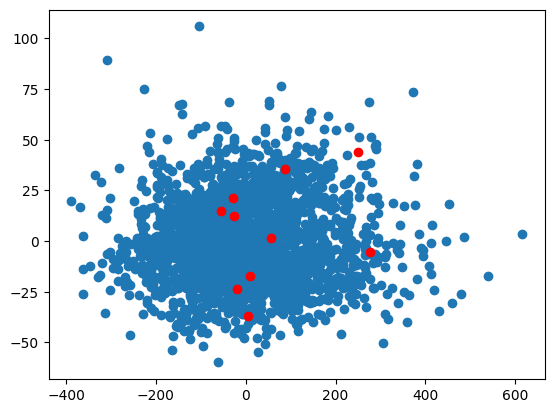

In [14]:
from matplotlib import pyplot as plt
plt.scatter(rest[:,0],rest[:,1])
plt.scatter(subset[:,0],subset[:,1], c='r')
plt.show()

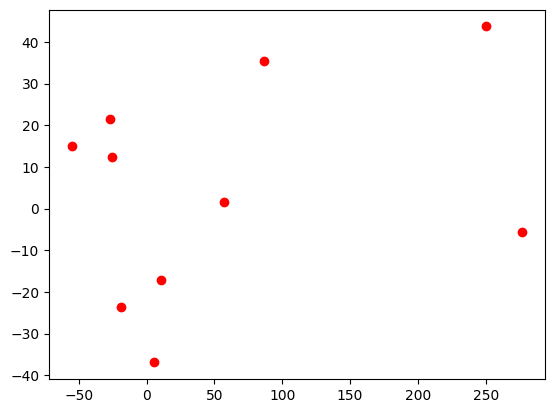

In [19]:
subset_pca = pca.transform(X[:10])
plt.scatter(subset_pca[:,0],subset_pca[:,1], c='r')
plt.show()

In [22]:
from pprint import pprin
pprint(subset_pca)
pprint(subset)

array([[ 86.69762205,  35.3649268 ],
       [  5.18869466, -36.91538364],
       [250.45246028,  43.69170885],
       [ 10.6163157 , -17.11559976],
       [-27.25340811,  21.43624339],
       [-18.75126386, -23.57539878],
       [277.1140919 ,  -5.60691964],
       [-55.3560147 ,  15.05930541],
       [-25.58949366,  12.44107706],
       [ 57.02157591,   1.62300918]])
array([[ 86.69762205,  35.3649268 ],
       [  5.18869466, -36.91538364],
       [250.45246028,  43.69170885],
       [ 10.6163157 , -17.11559976],
       [-27.25340811,  21.43624339],
       [-18.75126386, -23.57539878],
       [277.1140919 ,  -5.60691964],
       [-55.3560147 ,  15.05930541],
       [-25.58949366,  12.44107706],
       [ 57.02157591,   1.62300918]])


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, OPTICS
from AnalysisUtils import dr, clusters, features, helper, gpt
import json

def optics(X, min_samples=10, metric="cosine", **kwargs):
    scaler = StandardScaler()
    X = np.array(X)
    X = scaler.fit_transform(X)
    clustering = OPTICS(min_samples=min_samples, metric=metric).fit(X)
    return clustering.labels_

In [39]:
# metrics = ["readability", "formality", "sentiment", "faithfulness", "length"]
metrics = ["readability"]
dataset = json.load(open('data/tmp/df_summaries_features.json'))
target_features = list(map(lambda x: helper.filter_by_key(x['features'], metrics), dataset))
clusters = optics(target_features, min_samples=42, metric="cosine", auto_adjust=True)
cluster_labels = list(map(lambda l: str(l), set(clusters)))

/Users/samytlee/opt/anaconda3/envs/LLMEval/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [40]:
len(cluster_labels)

2

In [3]:
import json
dataset = json.load(open("data/tmp/df_summaries_features.json"))
dataset_w_topics = json.load(open("data/df_file.json"))
for i, datum in enumerate(dataset):
    assert(dataset[i]['text'] == dataset_w_topics[i]['text'])
    datum['topic'] = dataset_w_topics[i]['label']
    datum['id'] = i
save_json(dataset, "data/tmp/df_summaries_features_w_topics.json")

In [4]:
import numpy as np
def getEquidistantPoints(p1, p2, parts):
    return zip(*[np.linspace(p1[i], p2[i], parts+1) for i in range(len(p1))])
src_points=[
    [0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2]
]
dst_points=[
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
]
for src, dst in zip(src_points, dst_points):
    interpolation_points = np.array(list(getEquidistantPoints(src, dst, 5)))
    print(interpolation_points.shape)

(6, 5)
(6, 5)
(6, 5)


In [7]:
import json
from metrics.stylistic import StyleEvaluator
from AnalysisUtils import dr, clusters, features, helper, gpt
evaluator = features.StyleEvaluator()
metrics = ["complexity", "formality", "sentiment", "faithfulness", "naturalness", "length"]
dataset = json.load(open("data/tmp/df_summaries_features_w_topics.json"))
for i, datum in enumerate([dataset[365]]):
    print(i, len(dataset))
    text = datum['text']
    summary = datum['summary']
    datum['features'] = features.evaluate(evaluator, text, summary, metrics)
save_json(dataset, "data/tmp/df_summaries_new_features_w_topics.json")


0 2225
1 2225
2 2225
3 2225
4 2225
5 2225
6 2225
7 2225
8 2225
9 2225
10 2225
11 2225
12 2225
13 2225
14 2225
15 2225
16 2225
17 2225
18 2225
19 2225
20 2225
21 2225
22 2225
23 2225
24 2225
25 2225
26 2225
27 2225
28 2225
29 2225
30 2225
31 2225
32 2225
33 2225
34 2225
35 2225
36 2225
37 2225
38 2225
39 2225
40 2225
41 2225
42 2225
43 2225
44 2225
45 2225
46 2225
47 2225
48 2225
49 2225
50 2225
51 2225
52 2225
53 2225
54 2225
55 2225
56 2225
57 2225
58 2225
59 2225
60 2225
61 2225
62 2225
63 2225
64 2225
65 2225
66 2225
67 2225
68 2225
69 2225
70 2225
71 2225
72 2225
73 2225
74 2225
75 2225
76 2225
77 2225
78 2225
79 2225
80 2225
81 2225
82 2225
83 2225
84 2225
85 2225
86 2225
87 2225
88 2225
89 2225
90 2225
91 2225
92 2225
93 2225
94 2225
95 2225
96 2225
97 2225
98 2225
99 2225
100 2225
101 2225
102 2225
103 2225
104 2225
105 2225
106 2225
107 2225
108 2225
109 2225
110 2225
111 2225
112 2225
113 2225
114 2225
115 2225
116 2225
117 2225
118 2225
119 2225
120 2225
121 2225
122 2225
123

ZeroDivisionError: division by zero